In [1]:
%matplotlib inline

In [2]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression, Lasso

In [3]:
# yellowbrick.features.importances
# Feature importance visualizer
#
# Author:  Benjamin Bengfort <benjamin@bengfort.com>
# Created: Fri Mar 02 15:21:36 2018 -0500
# Author:  Rebecca Bilbro <rbilbro@districtdatalabs.com>
# Updated: Sun Jun 24 10:53:36 2018 -0500
#
# Copyright (C) 2018 District Data Labs
# For license information, see LICENSE.txt
#
# ID: importances.py [] benjamin@bengfort.com $

"""
Implementation of a feature importances visualizer. This visualizer sits in
kind of a weird place since it is technically a model scoring visualizer, but
is generally used for feature engineering.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.pyplot as plt

from yellowbrick.utils import is_dataframe
from yellowbrick.base import ModelVisualizer
from yellowbrick.exceptions import YellowbrickTypeError, NotFitted


##########################################################################
## Feature Visualizer
##########################################################################

class FeatureImportances(ModelVisualizer):
    """
    Displays the most informative features in a model by showing a bar chart
    of features ranked by their importances. Although primarily a feature
    engineering mechanism, this visualizer requires a model that has either a
    ``coef_`` or ``feature_importances_`` parameter after fit.

    Parameters
    ----------
    model : Estimator
        A Scikit-Learn estimator that learns feature importances. Must support
        either ``coef_`` or ``feature_importances_`` parameters.

    ax : matplotlib Axes, default: None
        The axis to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    labels : list, default: None
        A list of feature names to use. If a DataFrame is passed to fit and
        features is None, feature names are selected as the column names.

    relative : bool, default: True
        If true, the features are described by their relative importance as a
        percentage of the strongest feature component; otherwise the raw
        numeric description of the feature importance is shown.

    absolute : bool, default: False
        Make all coeficients absolute to more easily compare negative
        coeficients with positive ones.

    xlabel : str, default: None
        The label for the X-axis. If None is automatically determined by the
        underlying model and options provided.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    features_ : np.array
        The feature labels ranked according to their importance

    feature_importances_ : np.array
        The numeric value of the feature importance computed by the model

    Examples
    --------

    >>> from sklearn.ensemble import GradientBoostingClassifier
    >>> visualizer = FeatureImportances(GradientBoostingClassifier())
    >>> visualizer.fit(X, y)
    >>> visualizer.show()
    """

    def __init__(self, model, ax=None, labels=None, relative=True,
                 absolute=False, xlabel=None, **kwargs):
        super(FeatureImportances, self).__init__(model, ax, **kwargs)

        # Data Parameters
        self.set_params(
            labels=labels, relative=relative, absolute=absolute,
            xlabel=xlabel,
        )

    def fit(self, X, y=None, **kwargs):
        """
        Fits the estimator to discover the feature importances described by
        the data, then draws those importances as a bar plot.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target or class values

        kwargs : dict
            Keyword arguments passed to the fit method of the estimator.

        Returns
        -------
        self : visualizer
            The fit method must always return self to support pipelines.
        """
        super(FeatureImportances, self).fit(X, y, **kwargs)

        # Get the feature importances from the model
        self.feature_importances_ = self._find_importances_param()
        
        # Check if feature importances is a multidimensional array & if so flatten
        if self.feature_importances_.ndim > 1:
            self.feature_importances_ = np.mean(self.feature_importances_, axis=0)

        # Apply absolute value filter before normalization
        if self.absolute:
            self.feature_importances_ = np.abs(self.feature_importances_)

        # Normalize features relative to the maximum
        if self.relative:
            maxv = self.feature_importances_.max()
            self.feature_importances_ /= maxv
            self.feature_importances_ *= 100.0

        # Create labels for the feature importances
        # NOTE: this code is duplicated from MultiFeatureVisualizer
        if self.labels is None:
            # Use column names if a dataframe
            if is_dataframe(X):
                self.features_ = np.array(X.columns)

            # Otherwise use the column index as the labels
            else:
                _, ncols = X.shape
                self.features_ = np.arange(0, ncols)
        else:
            self.features_ = np.array(self.labels)

        # Sort the features and their importances
        sort_idx = np.argsort(self.feature_importances_)
        self.features_ = self.features_[sort_idx]
        self.feature_importances_ = self.feature_importances_[sort_idx]

        # Draw the feature importances
        self.draw()
        return self

    def draw(self, **kwargs):
        """
        Draws the feature importances as a bar chart; called from fit.
        """
        # Quick validation
        for param in ('feature_importances_', 'features_'):
            if not hasattr(self, param):
                raise NotFitted("missing required param '{}'".format(param))

        # Find the positions for each bar
        pos = np.arange(self.features_.shape[0]) + 0.5

        # Plot the bar chart
        self.ax.barh(pos, self.feature_importances_, align='center')

        # Set the labels for the bars
        self.ax.set_yticks(pos)
        self.ax.set_yticklabels(self.features_)

        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize the drawing setting labels and title.
        """
        # Set the title
        self.set_title('Feature Importances of {} Features using {}'.format(
                len(self.features_), self.name))

        # Set the xlabel
        self.ax.set_xlabel(self._get_xlabel())

        # Remove the ygrid
        self.ax.grid(False, axis='y')

        # Ensure we have a tight fit
        plt.tight_layout()

    def _find_importances_param(self):
        """
        Searches the wrapped model for the feature importances parameter.
        """
        for attr in ("feature_importances_", "coef_"):
            try:
                return getattr(self.estimator, attr)
            except AttributeError:
                continue

        raise YellowbrickTypeError(
            "could not find feature importances param on {}".format(
                self.estimator.__class__.__name__
            )
        )

    def _get_xlabel(self):
        """
        Determines the xlabel based on the underlying data structure
        """
        # Return user-specified label
        if self.xlabel:
            return self.xlabel

        # Label for coefficients
        if hasattr(self.estimator, "coef_"):
            if self.relative:
                return "relative coefficient magnitude"
            return "coefficient value"

        # Default label for feature_importances_
        if self.relative:
            return "relative importance"
        return "feature importance"

    def _is_fitted(self):
        """
        Returns true if the visualizer has been fit.
        """
        return hasattr(self, 'feature_importances_') and hasattr(self, 'features_')


##########################################################################
## Quick Method
##########################################################################

def feature_importances(model, X, y=None, ax=None, labels=None,
                        relative=True, absolute=False, xlabel=None, **kwargs):
    """
    Displays the most informative features in a model by showing a bar chart
    of features ranked by their importances. Although primarily a feature
    engineering mechanism, this visualizer requires a model that has either a
    ``coef_`` or ``feature_importances_`` parameter after fit.

    Parameters
    ----------
    model : Estimator
        A Scikit-Learn estimator that learns feature importances. Must support
        either ``coef_`` or ``feature_importances_`` parameters.

    X : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features

    y : ndarray or Series of length n, optional
        An array or series of target or class values

    ax : matplotlib Axes, default: None
        The axis to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    labels : list, default: None
        A list of feature names to use. If a DataFrame is passed to fit and
        features is None, feature names are selected as the column names.

    relative : bool, default: True
        If true, the features are described by their relative importance as a
        percentage of the strongest feature component; otherwise the raw
        numeric description of the feature importance is shown.

    absolute : bool, default: False
        Make all coeficients absolute to more easily compare negative
        coeficients with positive ones.

    xlabel : str, default: None
        The label for the X-axis. If None is automatically determined by the
        underlying model and options provided.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Returns
    -------
    ax : matplotlib axes
        Returns the axes that the parallel coordinates were drawn on.
    """
    # Instantiate the visualizer
    visualizer = FeatureImportances(
        model, ax, labels, relative, absolute, xlabel, **kwargs)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X, y)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax


# Binary Classification

In [4]:
occupancy = pd.read_csv('data/occupancy/occupancy.csv')
features = [
    "temperature", "relative humidity", "light", "C02", "humidity"
]
classes = ["unoccupied", "occupied"]
X = occupancy[features]
y = occupancy['occupancy']

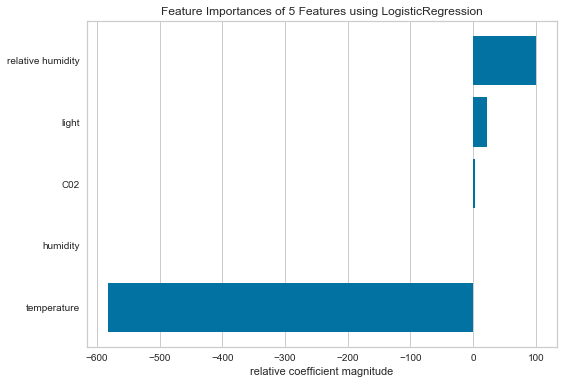

In [5]:
lr_importances = FeatureImportances(LogisticRegression())
lr_importances.fit(X,y)
lr_importances.show()

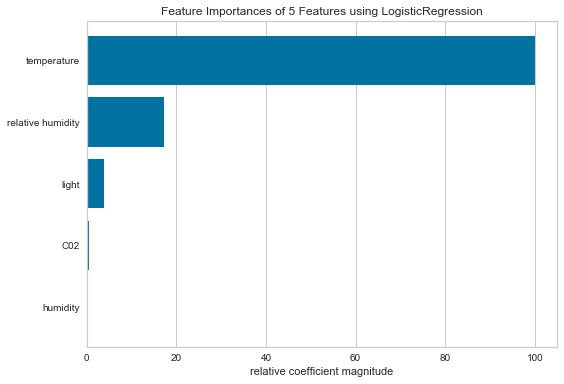

In [6]:
lr_importances = FeatureImportances(LogisticRegression(), absolute=True)
lr_importances.fit(X,y)
lr_importances.show()

# Multiclass Classification

In [7]:
game = pd.read_csv('data/game/game.csv')
classes = ["win", "loss", "draw"]

game.replace({'loss':-1, 'draw':0, 'win':1, 'x':2, 'o':3, 'b':4}, inplace=True)
X = game.iloc[:, game.columns != 'outcome']
y = game['outcome']

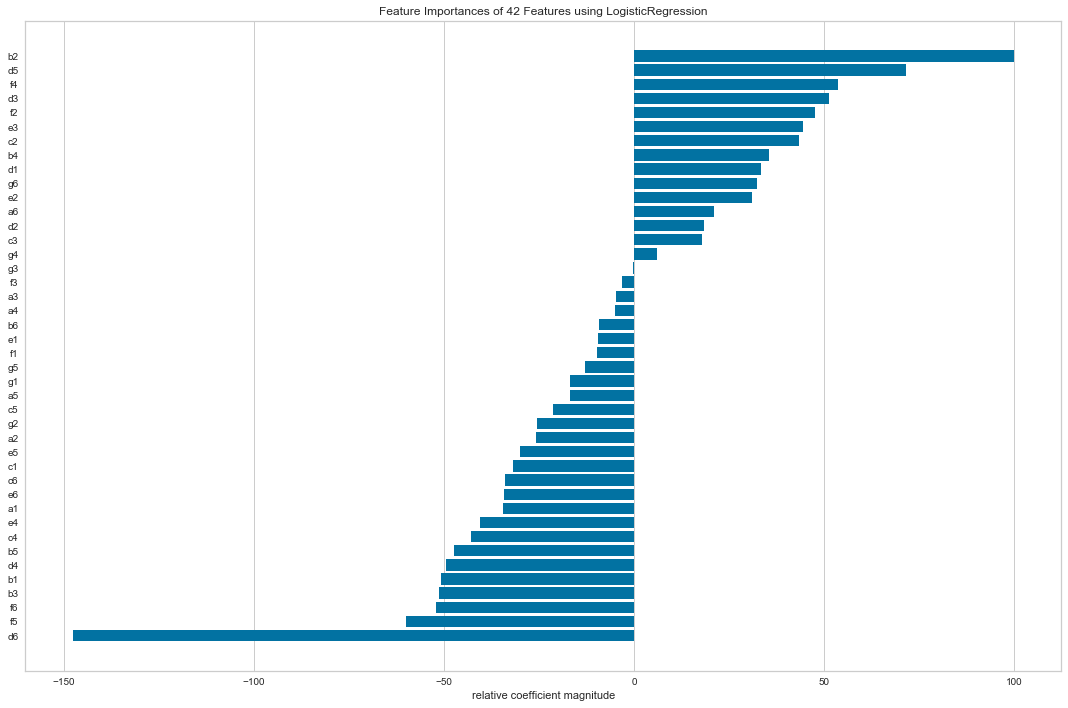

In [8]:
lr_importances = FeatureImportances(LogisticRegression(), size=(1080, 720))
lr_importances.fit(X,y)
lr_importances.show()

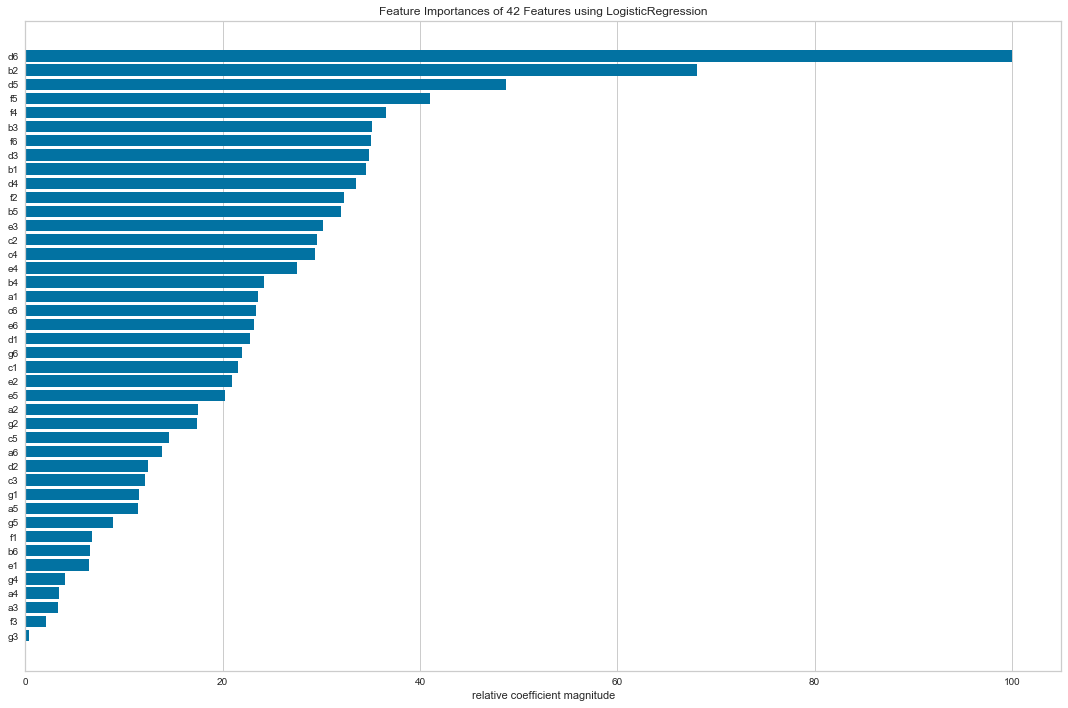

In [9]:
lr_importances = FeatureImportances(LogisticRegression(), absolute=True, size=(1080, 720))
lr_importances.fit(X,y)
lr_importances.show()